In [81]:
import keras.utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout

In [82]:
np.random.seed(5)

### Loading the data

In [83]:
df = pd.read_csv('chapter3_result_final.csv', index_col=0)

df.head()

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,hr_bpm,loc_speed,labelwalking,labelstanding,labelcycling,labelsitting,labeljogging,mag_x,mag_y,mag_z,pca_1,pca_2,pca_3,pca_4
2023-06-10 09:18:01.078849500,0.076690,-0.401173,-0.903155,0.035802,0.054908,0.017992,82.0,0.24,0,0,0,0,0,-105.695708,-61.086151,-254.083890,0.647343,0.038432,-0.157604,0.011235
2023-06-10 09:18:01.578849500,0.073643,-0.450106,-0.882250,0.055733,0.029957,0.028602,82.0,0.24,0,0,0,0,0,-105.492112,-62.742395,-252.361123,0.657564,0.048321,-0.141619,0.033916
2023-06-10 09:18:02.078849500,0.080184,-0.470433,-0.880101,0.028562,-0.003919,0.018485,81.5,0.24,0,0,0,0,0,-105.488211,-63.608722,-251.813753,0.664178,0.054162,-0.136757,0.043586
2023-06-10 09:18:02.578849500,0.081999,-0.458155,-0.893557,-0.022636,-0.039101,-0.005212,81.0,0.24,0,0,0,0,0,-105.885762,-63.500869,-252.515031,0.665825,0.050991,-0.140330,0.037175
2023-06-10 09:18:03.078849500,0.060238,-0.437311,-0.903372,-0.030354,-0.051831,-0.017089,80.5,0.12,1,0,0,0,0,-106.644231,-62.939380,-253.436460,0.667007,0.030437,-0.148166,0.031710


In [84]:
# Store the label columns
LABEL_COLUMNS = [column for column in df.columns if 'label' in column]

In [85]:
# start by removing instances that does not have a label assigned to them.
df = df.loc[df[LABEL_COLUMNS].any(axis = 1).values].copy()


In [86]:
# Reverse the one-hot encoding procedure. This will help us later when we create sequences.
df['activity'] = df[LABEL_COLUMNS].idxmax(1)

# Drop one-hot encoded labels for now.
df.drop(LABEL_COLUMNS, axis = 1, inplace = True)
df.head()

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,hr_bpm,loc_speed,mag_x,mag_y,mag_z,pca_1,pca_2,pca_3,pca_4,activity
2023-06-10 09:18:03.078849500,0.060238,-0.437311,-0.903372,-0.030354,-0.051831,-0.017089,80.5,0.12,-106.644231,-62.939380,-253.436460,0.667007,0.030437,-0.148166,0.031710,labelwalking
2023-06-10 09:18:03.578849500,0.027379,-0.437199,-0.898040,0.024199,-0.026543,-0.007163,80.0,0.00,-107.296849,-62.698251,-253.549791,0.669788,0.010870,-0.147697,0.033960,labelwalking
2023-06-10 09:18:04.078849500,0.020393,-0.464055,-0.884296,0.079175,0.015828,0.003371,79.5,0.00,-107.338538,-63.203467,-252.812118,0.674309,0.012883,-0.138789,0.043026,labelwalking
2023-06-10 09:18:04.578849500,0.049570,-0.496552,-0.873227,0.071525,0.027209,-0.008937,79.0,0.00,-106.910903,-64.261546,-252.005083,0.680771,0.027118,-0.136339,0.059556,labelwalking
2023-06-10 09:18:05.078849500,0.073128,-0.512116,-0.864466,0.023229,-0.011262,-0.026929,78.5,0.00,-106.853579,-65.314716,-251.720021,0.685483,0.036832,-0.134543,0.070629,labelwalking


In [87]:
# Drop the PCA for now
df.drop([col for col in df.columns if 'pca' in col], axis = 1, inplace = True)

df.head()

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,hr_bpm,loc_speed,mag_x,mag_y,mag_z,activity
2023-06-10 09:18:03.078849500,0.060238,-0.437311,-0.903372,-0.030354,-0.051831,-0.017089,80.5,0.12,-106.644231,-62.939380,-253.436460,labelwalking
2023-06-10 09:18:03.578849500,0.027379,-0.437199,-0.898040,0.024199,-0.026543,-0.007163,80.0,0.00,-107.296849,-62.698251,-253.549791,labelwalking
2023-06-10 09:18:04.078849500,0.020393,-0.464055,-0.884296,0.079175,0.015828,0.003371,79.5,0.00,-107.338538,-63.203467,-252.812118,labelwalking
2023-06-10 09:18:04.578849500,0.049570,-0.496552,-0.873227,0.071525,0.027209,-0.008937,79.0,0.00,-106.910903,-64.261546,-252.005083,labelwalking
2023-06-10 09:18:05.078849500,0.073128,-0.512116,-0.864466,0.023229,-0.011262,-0.026929,78.5,0.00,-106.853579,-65.314716,-251.720021,labelwalking


## Building the dataset

In [88]:
def createSequences(X, y, window_size, step):
    Xs, ys = [], []

    for i in range(0, len(X) - window_size, step):
        partition = X.iloc[i: (i + window_size)].values
        labels = y.iloc[i: i + window_size]

        Xs.append(partition)
        ys.append(labels.value_counts().index[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)


def composeDataset(df, window_size, step):
    X  = df.drop('activity', axis = 1)
    y = df['activity']

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.2)

    X_train_seq, y_train_seq = createSequences(X_train, y_train, window_size, step)
    X_test_seq, y_test_seq = createSequences(X_test, y_test, window_size, step)

    enc = OneHotEncoder( sparse_output=False).fit(y_train_seq)

    y_train_seq = enc.transform(y_train_seq)
    y_test_seq = enc.transform(y_test_seq)

    return X_train_seq, X_test_seq, y_train_seq, y_test_seq

# Model

In [89]:
X_train, X_test, y_train, y_test = composeDataset(df, 10, 5)

X_test.shape

(379, 10, 11)

In [90]:

model = Sequential()

model.add(LSTM( units=128, input_shape=[X_train.shape[1], X_train.shape[2]]))
model.add(Dropout(rate=0.5))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))


model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['acc'], )

In [91]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 128)               71680     
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_56 (Dense)            (None, 128)               16512     
                                                                 
 dense_57 (Dense)            (None, 5)                 645       
                                                                 
Total params: 88837 (347.02 KB)
Trainable params: 88837 (347.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [92]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1)

Epoch 1/30
43/43 [==============================] - 1s 14ms/step - loss: 1.2776 - acc: 0.4700 - val_loss: 1.1577 - val_acc: 0.6275
Epoch 2/30
43/43 [==============================] - 0s 5ms/step - loss: 0.9223 - acc: 0.6308 - val_loss: 1.3335 - val_acc: 0.6275
Epoch 3/30
43/43 [==============================] - 0s 5ms/step - loss: 0.8518 - acc: 0.6484 - val_loss: 1.1822 - val_acc: 0.6405
Epoch 4/30
43/43 [==============================] - 0s 5ms/step - loss: 0.7909 - acc: 0.6827 - val_loss: 1.2894 - val_acc: 0.6601
Epoch 5/30
43/43 [==============================] - 0s 5ms/step - loss: 0.7397 - acc: 0.6849 - val_loss: 1.4223 - val_acc: 0.6601
Epoch 6/30
43/43 [==============================] - 0s 6ms/step - loss: 0.7255 - acc: 0.6952 - val_loss: 1.5004 - val_acc: 0.6405
Epoch 7/30
43/43 [==============================] - 0s 5ms/step - loss: 0.6686 - acc: 0.7178 - val_loss: 1.1424 - val_acc: 0.6732
Epoch 8/30
43/43 [==============================] - 0s 5ms/step - loss: 0.6560 - acc: 0.7

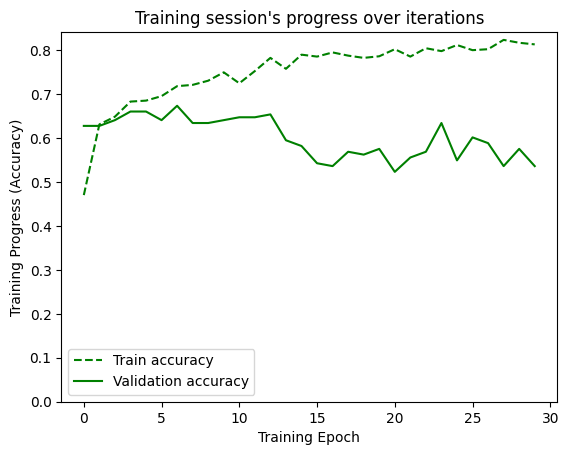

In [93]:
plt.plot(np.array(history.history['acc']), "g--", label = "Train accuracy")
plt.plot(np.array(history.history['val_acc']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

After running our initial run, we see that the gap between the validation/training is quite large. Indicating that we are probabily overfitting. To counter that we are going to do two approaches
- Run the model again with a selection of features, instead of all
- Reduce the overlap in sequences

First let's create a function of the model for easy access

In [94]:
def runModel(units, num_output, input_shape):
    m = Sequential()
    m.add(LSTM( units=units, input_shape=[input_shape[1], input_shape[2]]))
    m.add(Dropout(rate=0.5)) # To avoid overfitting
    m.add(Dense(units=units, activation='relu'))
    m.add(Dense(num_output, activation='softmax'))
    m.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    return m

def drawModelResult(history):
    plt.plot(np.array(history.history['acc']), "g--", label = "Train accuracy")
    plt.plot(np.array(history.history['val_acc']), "g-", label = "Validation accuracy")
    plt.title("Training session's progress over iterations")
    plt.legend(loc='lower left')
    plt.ylabel('Training Progress (Accuracy)')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.show()




### Less featuers
Here we try to run the model with fewer features

Epoch 1/30
43/43 [==============================] - 1s 10ms/step - loss: 1.3371 - acc: 0.4335 - val_loss: 1.0159 - val_acc: 0.6275
Epoch 2/30
43/43 [==============================] - 0s 6ms/step - loss: 0.9296 - acc: 0.5833 - val_loss: 1.0625 - val_acc: 0.6013
Epoch 3/30
43/43 [==============================] - 0s 5ms/step - loss: 0.7306 - acc: 0.6820 - val_loss: 1.3077 - val_acc: 0.4837
Epoch 4/30
43/43 [==============================] - 0s 5ms/step - loss: 0.6626 - acc: 0.7149 - val_loss: 1.0847 - val_acc: 0.5948
Epoch 5/30
43/43 [==============================] - 0s 5ms/step - loss: 0.7082 - acc: 0.6944 - val_loss: 1.6682 - val_acc: 0.4837
Epoch 6/30
43/43 [==============================] - 0s 6ms/step - loss: 0.6230 - acc: 0.7383 - val_loss: 1.2213 - val_acc: 0.5490
Epoch 7/30
43/43 [==============================] - 0s 5ms/step - loss: 0.5862 - acc: 0.7493 - val_loss: 1.4877 - val_acc: 0.5556
Epoch 8/30
43/43 [==============================] - 0s 5ms/step - loss: 0.6014 - acc: 0.7

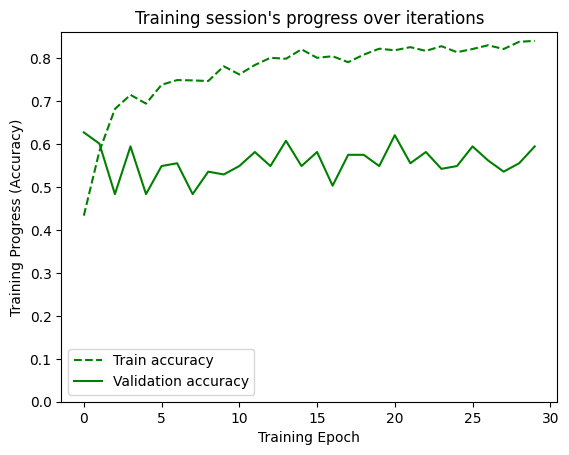

In [95]:
selected_features = df[['activity', 'acc_x', 'acc_y', 'acc_z', 'loc_speed', 'hr_bpm']]

X_train, X_test, y_train, y_test = composeDataset(selected_features, 10, 5)

model = runModel(128, y_train.shape[1], X_train.shape)
history = model.fit( X_train, y_train, epochs=30,batch_size=32, validation_split=0.1)

drawModelResult(history)

## Even less features

Epoch 1/30
43/43 [==============================] - 1s 9ms/step - loss: 1.2343 - acc: 0.5058 - val_loss: 0.8652 - val_acc: 0.6471
Epoch 2/30
43/43 [==============================] - 0s 5ms/step - loss: 0.8902 - acc: 0.6352 - val_loss: 0.8624 - val_acc: 0.6405
Epoch 3/30
43/43 [==============================] - 0s 5ms/step - loss: 0.8273 - acc: 0.6499 - val_loss: 0.8898 - val_acc: 0.6471
Epoch 4/30
43/43 [==============================] - 0s 5ms/step - loss: 0.8015 - acc: 0.6732 - val_loss: 0.7584 - val_acc: 0.6536
Epoch 5/30
43/43 [==============================] - 0s 5ms/step - loss: 0.7653 - acc: 0.6959 - val_loss: 0.7411 - val_acc: 0.6536
Epoch 6/30
43/43 [==============================] - 0s 5ms/step - loss: 0.6943 - acc: 0.7244 - val_loss: 0.5929 - val_acc: 0.7647
Epoch 7/30
43/43 [==============================] - 0s 5ms/step - loss: 0.6274 - acc: 0.7493 - val_loss: 0.6163 - val_acc: 0.7582
Epoch 8/30
43/43 [==============================] - 0s 5ms/step - loss: 0.6017 - acc: 0.76

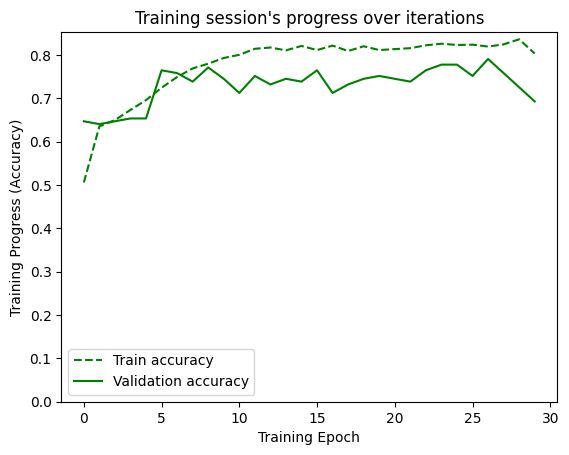

In [96]:
selected_features = df[['activity', 'acc_x', 'acc_y', 'acc_z']]

X_train, X_test, y_train, y_test = composeDataset(selected_features, 10, 5)

model = runModel(128, y_train.shape[1], X_train.shape)
history = model.fit( X_train, y_train, epochs=30,batch_size=32, validation_split=0.1, shuffle = True)

drawModelResult(history)

In [97]:
_, acc = model.evaluate(X_test, y_test)

print(acc)

12/12 [==============================] - 0s 2ms/step - loss: 1.0466 - acc: 0.5831
0.583113431930542


### Less window overlap

In [115]:
    X_train, X_test, y_train, y_test = composeDataset(df, 20, 18)

model = runModel(128, y_train.shape[1], X_train.shape)
history = model.fit( X_train, y_train, epochs=30,batch_size=32, validation_split=0.1)

drawModelResult(history)

(1521, 10, 11)

## Let's split the data randomly

In [107]:
X  = df.drop('activity', axis = 1)
y = df['activity']

Xs, ys = createSequences(X, y, 10, 8)

X_train, X_test, y_train, y_test = train_test_split(Xs, ys, shuffle=True, test_size=.2)

enc = OneHotEncoder( sparse_output=False).fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)


Epoch 1/50
27/27 [==============================] - 1s 12ms/step - loss: 1.3488 - acc: 0.5146 - val_loss: 1.0475 - val_acc: 0.6316
Epoch 2/50
27/27 [==============================] - 0s 6ms/step - loss: 0.9395 - acc: 0.6374 - val_loss: 0.7950 - val_acc: 0.6632
Epoch 3/50
27/27 [==============================] - 0s 5ms/step - loss: 0.8216 - acc: 0.6526 - val_loss: 0.7029 - val_acc: 0.7158
Epoch 4/50
27/27 [==============================] - 0s 5ms/step - loss: 0.7446 - acc: 0.6982 - val_loss: 0.7128 - val_acc: 0.7474
Epoch 5/50
27/27 [==============================] - 0s 6ms/step - loss: 0.6934 - acc: 0.7240 - val_loss: 0.6521 - val_acc: 0.7474
Epoch 6/50
27/27 [==============================] - 0s 6ms/step - loss: 0.6674 - acc: 0.7357 - val_loss: 0.6372 - val_acc: 0.7789
Epoch 7/50
27/27 [==============================] - 0s 6ms/step - loss: 0.6224 - acc: 0.7626 - val_loss: 0.6074 - val_acc: 0.7895
Epoch 8/50
27/27 [==============================] - 0s 6ms/step - loss: 0.5822 - acc: 0.7

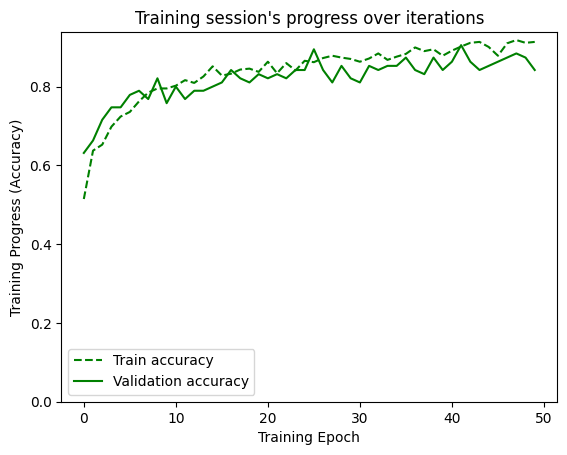

In [110]:

model = Sequential()


model.add(LSTM( units=128, input_shape=[X_train.shape[1], X_train.shape[2]]))
# model.add(Dropout(rate=0.5))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

history = model.fit(X_train, y_train, epochs=50,batch_size=32, validation_split=0.1)

drawModelResult(history)

In [111]:
_, acc = model.evaluate(X_test, y_test)

print(acc)

8/8 [==============================] - 0s 2ms/step - loss: 0.5331 - acc: 0.8319
0.831932783126831
